# Segmenting and Clustering Neighborhoods in Toronto

### Project Discription
  This project includes the following components:
1. scraping the Wikipedia page for the postal codes of Canada
2. process and clean the data for the clustering
3. use K Means to do the clustering and use  Folium Library to  plotted the cluster

### Preparation: Installing and Importing the required Libraries

In [3]:
!pip install beautifulsoup4
!pip install lxml
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\a2152327\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py38haa244fe_0         3.1 MB  conda-forge
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.2.0                |     pyhd8ed1ab_0          67 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.2.0-pyhd8ed1ab_0
  python_abi         conda-forge/win-64::python_abi-3.8-2_cp38

The follow



==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\a2152327\Anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

  altair             conda-forge/noarch::altair-4.1.0-py_1
  branca             conda-forge/noarch::branca-

## 1. Scraping the Wikipedia page for the table of postal codes of Canada

In [ ]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(source,'lxml')
print(soup.title)
from IPython.display import display_html
tab = str(soup.table)
display_html(tab,raw=True)

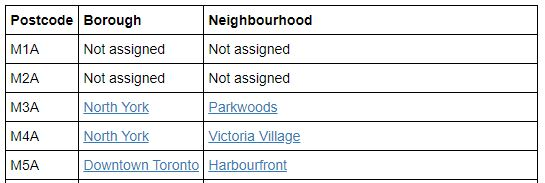

### Converting the html table to Pandas Data Frame for cleaning and preprocessing

In [ ]:
dfs = pd.read_html(tab)
df=dfs[0]
df.head()

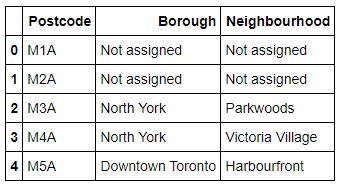

## 2. Preprocessing and cleaning data for clustering

In [ ]:
# Dropping the rows where Borough is 'Not assigned'
df1 = df[df.Borough != 'Not assigned']

# Combining the neighbourhoods with same Postalcode
df2 = df1.groupby(['Postcode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
df2['Neighbourhood'] = np.where(df2['Neighbourhood'] == 'Not assigned',df2['Borough'], df2['Neighbourhood'])

df2

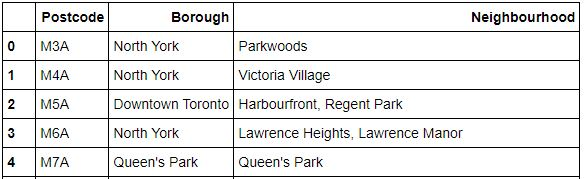

In [ ]:
# Shape of data frame
df2.shape

In [ ]:
(103, 3)

### Importing the csv file which conatins the latitudes and longitudes for neighbourhoods in Canada

In [ ]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

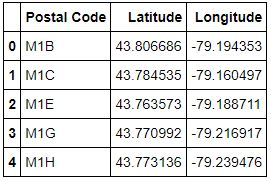

### Merging the above two tables in order to get the Latitudes and Longitudes for neighbourhoods in Canada

In [ ]:
lat_lon.rename(columns={'Postal Code':'Postcode'},inplace=True)
df3 = pd.merge(df2,lat_lon,on='Postcode')
df3.head()

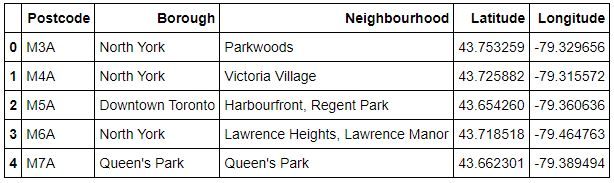

## 3. Clustering and the plotting of the neighbourhoods which contain Toronto in their Borough

### Getting  rows from the data frame which contains Toronto in their Borough.

In [ ]:
df4 = df3[df3['Borough'].str.contains('Toronto',regex=False)]
df4

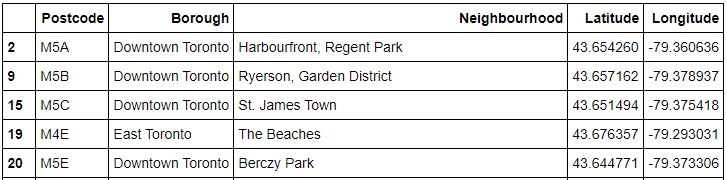

### Visualizing the Neighbourhoods of the above data frame using Folium

In [ ]:
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df4['Latitude'],df4['Longitude'],df4['Borough'],df4['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

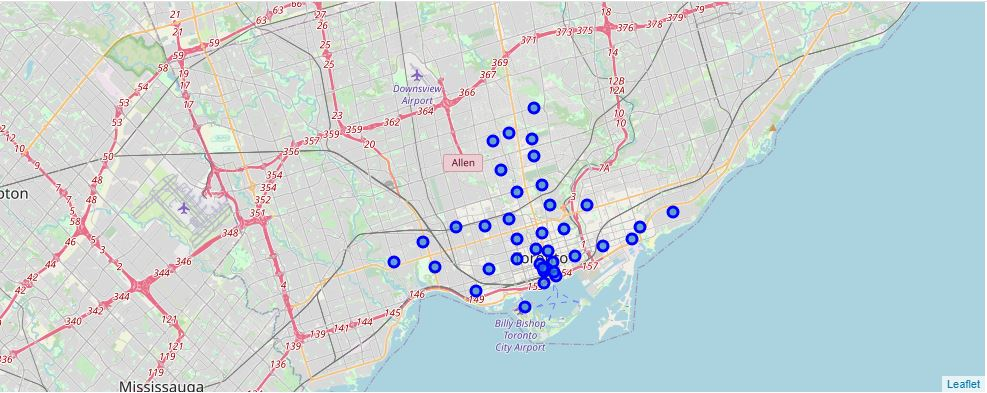

### Using KMeans clustering for the clustering of the neighbourhoods

In [ ]:
k=5
toronto_clustering = df4.drop(['Postcode','Borough','Neighbourhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans.labels_
df4.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
array([0, 0, 0, 3, 0, 0, 2, 0, 4, 0, 2, 3, 0, 2, 3, 0, 3, 1, 1, 1, 1, 4,
       1, 2, 4, 1, 2, 4, 1, 2, 1, 0, 0, 0, 0, 0, 0, 3], dtype=int32)

In [ ]:
df4

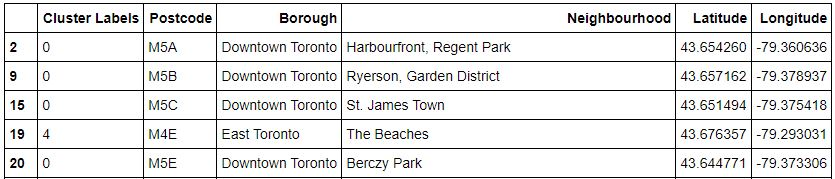

### creating the  map of the clsutering of the neighbourhoods

In [ ]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df4['Latitude'], df4['Longitude'], df4['Neighbourhood'], df4['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


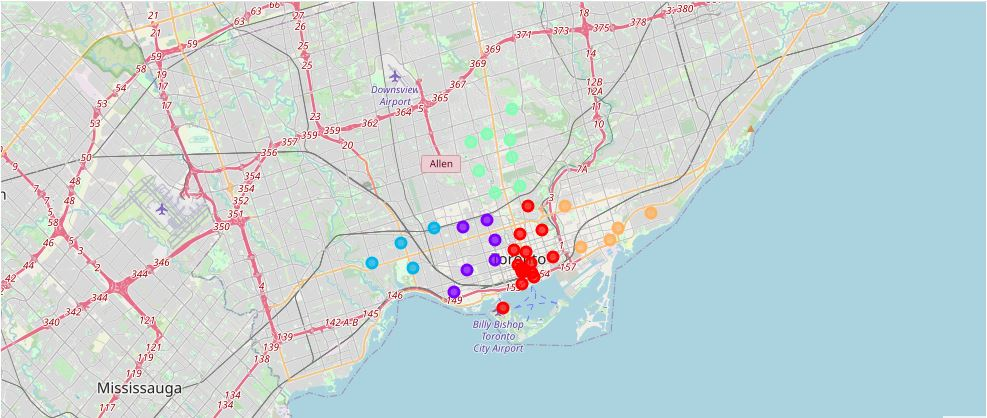